## Problem Statement:
iPrint is an upcoming media house in India that offers media and information services to the people. The company’s business extends across a wide range of media, including news and information services on sports, weather, education, health, research, stocks and healthcare. Over the years, through its online application, iPrint has been efficiently delivering news and information to the common people.  However, with time and technological advancements, several new competitors of iPrint have emerged in the market. Hence, it has decided to begin providing a more personalised experience to its customers.

The problem statement can be divided into two parts.
- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user.

You have to ensure that the system does not recommend any news article that has been pulled out from the app or has already been seen by the user. In addition, only the articles that are written in the English language must be considered for content-based recommendations. The final generated list must contain the names of the recommended articles, along with their IDs.

### Load the required library:

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora.dictionary import Dictionary
import string
from gensim.models.tfidfmodel import TfidfModel

from gensim.similarities import MatrixSimilarity

### Load Dataset:

In [2]:
consumer = pd.read_csv(r"consumer_transanctions.csv")
content= pd.read_csv(r"platform_content.csv")

- Consumer dataframe is similar to User dataset.
- Content dataframe is similar to item dataset.

### Consumer Dataset Exploration :

In [3]:
consumer.columns # Check columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'consumer_id',
       'consumer_session_id', 'consumer_device_info', 'consumer_location',
       'country'],
      dtype='object')

In [4]:
consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [5]:
# Check null values in Consumer data
consumer.isnull().sum()

event_timestamp             0
interaction_type            0
item_id                     0
consumer_id                 0
consumer_session_id         0
consumer_device_info    15394
consumer_location       15405
country                 15394
dtype: int64

- __Item ID and Consumer ID do not have any null values.__

In [6]:
#Check the metadata
consumer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [7]:
#Created Label Encoder for easy interpretation of Consumer ID  and create a new column Consumer Index


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
consumer["consumer_index"] = le.fit_transform(consumer["consumer_id"])

In [8]:
consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887


### Rating assignment to column interaction type
- __New column ratings will be created below by imputing interaction_type__.

In [9]:
#Check no of unique items in interaction type
consumer["interaction_type"].unique()

array(['content_watched', 'content_followed', 'content_saved',
       'content_liked', 'content_commented_on'], dtype=object)

In [10]:
# Map each interacion type to appropriate value as per suggestion

rate = {'content_followed':5,
        'content_commented_on':4,
        'content_saved':3,
        'content_liked':2,
        'content_watched': 1
        }

In [11]:
# create numeric column ratings from interaction type
consumer["ratings"] = consumer["interaction_type"].map(rate)

In [12]:
# Check the imputed data
consumer[["ratings","interaction_type"]].head()

,ratings,interaction_type
0,1,content_watched
1,1,content_watched
2,1,content_watched
3,5,content_followed
4,1,content_watched


In [13]:
# Check the percentage distribution of interaction type
consumer["interaction_type"].value_counts(normalize=True)

content_watched         0.844756
content_liked           0.079447
content_saved           0.034061
content_commented_on    0.022278
content_followed        0.019457
Name: interaction_type, dtype: float64

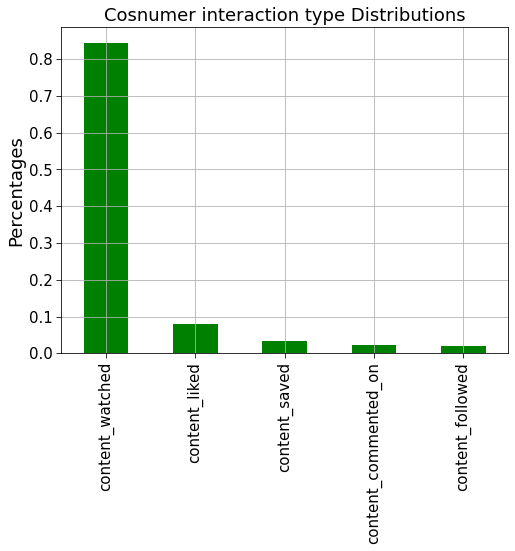

In [14]:
# plot  a BAR grah of the distribution 
plt.figure(figsize=(8,6))
plt.title("Cosnumer interaction type Distributions",fontsize=18)
consumer["interaction_type"].value_counts(normalize=True).plot.bar(color="green")
plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.grid(0.3)

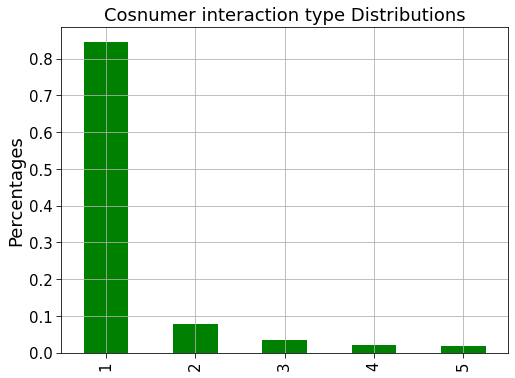

In [15]:
# check ratings data distributions 
plt.figure(figsize=(8,6))
plt.title("Cosnumer interaction type Distributions",fontsize=18)
consumer["ratings"].value_counts(normalize=True).plot.bar(color="green")

plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.grid(0.3)

- __80% of data was rated as 1 --> content watched.__

In [16]:
#check the location values 
consumer["consumer_location"].unique()

array([nan, 'NY', 'MG', 'SP', 'RJ', 'GA', 'CA', '?', 'NJ', 'TX', '49',
       'MH', 'D', 'PA', 'VA', 'BE', 'AZ', 'IL', 'MI', 'FL', 'ES', 'BW',
       'MA', 'PR', 'BC', 'NSW', 'DF', 'C', 'HE', 'ON', 'MS', '13', '11',
       'DC', 'NE', 'NC', '33', 'CO', 'LA', 'ENG', 'GO', '14', 'IN', 'CT',
       '45', '27', 'WA', 'PE', 'MO', 'MN', 'RS', 'NH', '41', 'SC', 'BA',
       'WI', 'RM', 'OK', 'OH', 'CE', 'RI', 'AB', 'R', 'BOL', 'NV', 'OR',
       'KS', 'ZH', 'MT', 'QLD', 'PI', 'CL'], dtype=object)

In [17]:
#check the percentage distribution of User Location 
consumer["consumer_location"].value_counts(normalize=True)


SP    0.705783
MG    0.179749
NY    0.022089
TX    0.016219
GA    0.015991
        ...   
R     0.000018
CE    0.000018
NH    0.000018
MN    0.000018
CL    0.000018
Name: consumer_location, Length: 71, dtype: float64

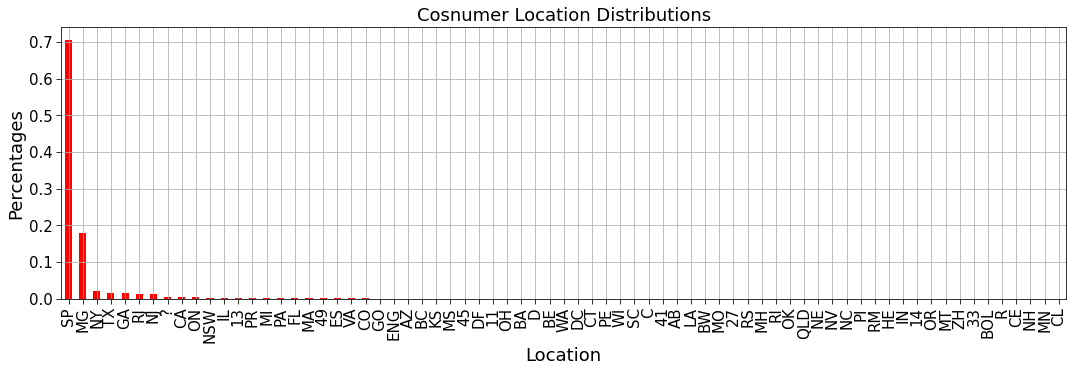

In [18]:
#Plot the user location with BAR Graph
plt.figure(figsize=(18,5))
plt.title("Cosnumer Location Distributions",fontsize=18)
consumer["consumer_location"].value_counts(normalize=True).plot.bar(color="red")

plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.xlabel("Location",fontsize=18)
plt.grid(0.3)

- __SP (sao paulo) has highest percentages of location share.__

In [19]:
# Check the consumer country percentage distributions
consumer["country"].value_counts(normalize=True).round(2)

BR    0.90
US    0.08
KR    0.00
CA    0.00
JP    0.00
AU    0.00
GB    0.00
DE    0.00
IE    0.00
IS    0.00
ZZ    0.00
SG    0.00
AR    0.00
PT    0.00
ES    0.00
IN    0.00
MY    0.00
IT    0.00
CN    0.00
NL    0.00
CL    0.00
CO    0.00
CH    0.00
Name: country, dtype: float64

- __90% of data belongs to country Brazil.__

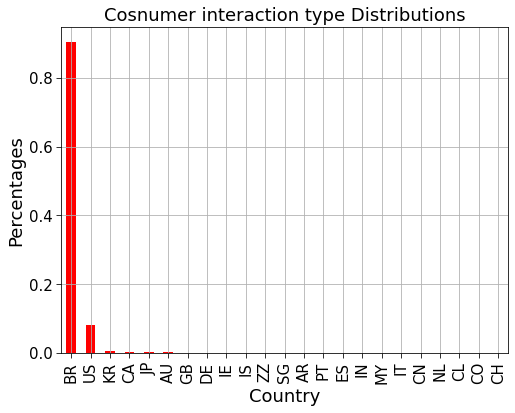

In [20]:
#plot country percentage distributions
plt.figure(figsize=(8,6))
plt.title("Cosnumer interaction type Distributions",fontsize=18) #title
consumer["country"].value_counts(normalize=True).plot.bar(color="red") 
plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.xlabel("Country",fontsize=18)
plt.grid(0.3)

In [21]:
consumer["consumer_device_info"].value_counts(normalize=True)

Android - Native Mobile App                                                                                                                          0.118785
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                       0.032029
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                       0.020134
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                            0.018904
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                        0.018606
                                                                                                                                                       ...   
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.

 - __12% consumer access the news items via Android native mobile app__.

In [22]:
# percentange of consumer access news via Chrome
consumer["consumer_device_info"].str.contains("Chrome").sum()/len(consumer)

0.6650901648412435

- __Close to 66% user access new items via Chrome browser.__

In [23]:
consumer["consumer_device_info"].str.contains("Mozilla").sum()/len(consumer)

0.6921949330678172

- __Close to 69% user access new items via Mozilla browser.__

In [24]:
consumer["consumer_device_info"].str.contains("AppleWebKit").sum()/len(consumer)

0.6770245602389645

In [25]:
consumer["consumer_device_info"].str.contains("Safari").sum()/len(consumer)

0.6770245602389645

- __From the above analysis, users actually access newitems simultaneouly from different browsers.__
- __There is no clear cut interpretation of device info from the data.__ 

## Content Data Exploration:

In [26]:
content.columns #Check content columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'producer_id',
       'producer_session_id', 'producer_device_info', 'producer_location',
       'producer_country', 'item_type', 'item_url', 'title',
       'text_description', 'language'],
      dtype='object')

In [27]:
content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [28]:
content.isnull().sum() # Chck null values

event_timestamp            0
interaction_type           0
item_id                    0
producer_id                0
producer_session_id        0
producer_device_info    2442
producer_location       2442
producer_country        2442
item_type                  0
item_url                   0
title                      0
text_description           0
language                   0
dtype: int64

- __We have null values in producer_device_info, producer_location  and producer_country.__
  

In [29]:
content["title"].loc[5] # check  title it looks

'IEEE to Talk Blockchain at Cloud Computing Oxford-Con - CoinDesk'

In [30]:
content.info() # Metadata Check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [31]:
content.interaction_type.unique() # Check the interaction type column in Content dataset

array(['content_pulled_out', 'content_present'], dtype=object)

In [32]:
len(content) # no of entries in content column

3122

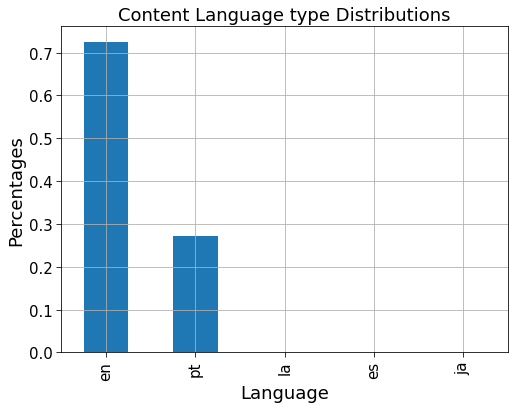

In [33]:
## Check the language distributions in news content

plt.figure(figsize=(8,6))
plt.title("Content Language type Distributions",fontsize=18)
content["language"].value_counts(normalize=True).plot.bar()
plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.xlabel("Language",fontsize=18)
plt.grid(0.3)

 - __72% data belongs to english contents.__

<AxesSubplot:ylabel='language'>

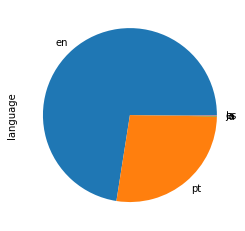

In [34]:
content["language"].value_counts(normalize=True).plot.pie() # language percentages distributions

### Filtered the English News Contents

In [35]:
english_content = content[content["language"]=="en"]

In [36]:
len(english_content)

2264

In [37]:
# Label Encoding of Item ID in english content and Consumer content.

le_item = LabelEncoder()
english_content["item_index"] = le_item.fit_transform(english_content["item_id"])

consumer["item_index"] = le_item.fit_transform(consumer["item_id"])



In [38]:
consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index,ratings,item_index
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33,1,933
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831,1,2933
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826,1,1537
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974,5,1537
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887,1,246


In [39]:
#Verify if label encoding encoded correctly by comparing item id and item index
english_content["item_id"].nunique()


2218

In [40]:
english_content["item_index"].nunique()

2218

In [41]:
# Similarly check consumer item id and consumer item index
consumer["item_id"].nunique()

2987

In [42]:
consumer["item_index"].nunique()

2987

In [43]:
consumer["consumer_id"].nunique()

1895

- __Consumer dataset has 2987 unique items.__ 
- __English Content dataset has 2218 unique items.__ 
- __Consumer dataset has 1895 unique users.__ 

### Verify if  index is correct   in consumer and content data:

In [44]:
set_consumer = set(consumer.item_id.unique())

In [45]:
set_content = set(english_content.item_id.unique())

In [46]:
len(set_consumer & set_content)

2154

In [47]:
len(set_consumer.difference(set_content))

833

In [48]:
2987-2218

769

In [49]:
len(set_content.difference(set_consumer))

64

- __769 items are not available in english content data.__

### Explore English Content:

In [50]:
english_content["item_type"].value_counts(normalize=True) #check percentage distributions of item type

HTML     0.994700
VIDEO    0.003092
RICH     0.002208
Name: item_type, dtype: float64

- __all most all of the contents are html type.__

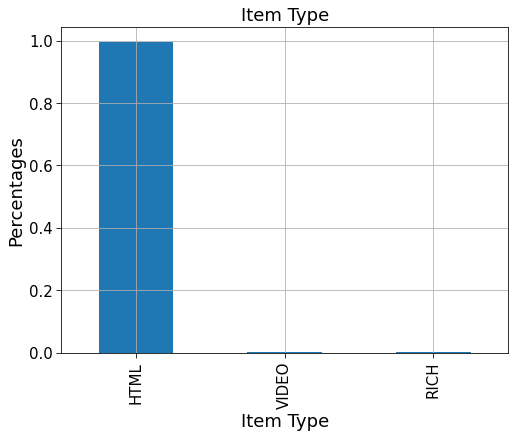

In [51]:
plt.figure(figsize=(8,6))
plt.title("Item Type",fontsize=18)
english_content["item_type"].value_counts(normalize=True).plot.bar()
plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.xlabel("Item Type",fontsize=18)
plt.grid(0.3)

In [52]:
# Country wise percentages of news content
content["producer_country"].value_counts(normalize=True).round(2)



BR    0.90
US    0.09
CA    0.01
AU    0.00
PT    0.00
Name: producer_country, dtype: float64

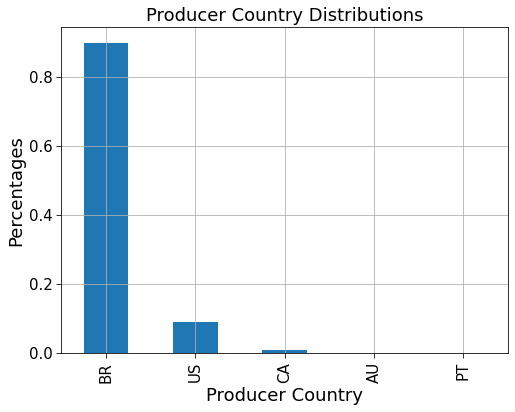

In [53]:
#Country wise percentages of news content with bar plot
# content["producer_country"].value_counts(normalize=True).round(2).plot.bar()

plt.figure(figsize=(8,6))
plt.title("Producer Country Distributions",fontsize=18)
content["producer_country"].value_counts(normalize=True).round(2).plot.bar()
plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.xlabel("Producer Country",fontsize=18)
plt.grid(0.3)

- __90% contents are generated from country Brazil.__

In [54]:
# location wise  percentages of news content
content["producer_location"].value_counts(normalize=True)

SP     0.783824
MG     0.110294
NY     0.029412
NJ     0.023529
GA     0.010294
IL     0.008824
ON     0.005882
RJ     0.005882
NSW    0.002941
TX     0.002941
?      0.002941
SC     0.002941
RI     0.001471
AB     0.001471
FL     0.001471
13     0.001471
WA     0.001471
CA     0.001471
MS     0.001471
Name: producer_location, dtype: float64

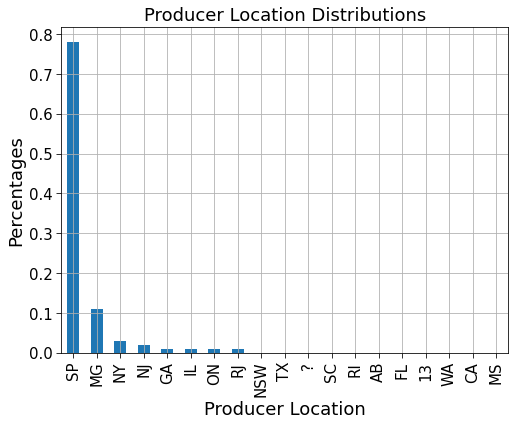

In [55]:
# location wise  percentages of news content with BAR graph
# content["producer_location"].value_counts(normalize=True).round(2).plot.bar()


plt.figure(figsize=(8,6))
plt.title("Producer Location Distributions",fontsize=18)
content["producer_location"].value_counts(normalize=True).round(2).plot.bar()
plt.tick_params(size=5,labelsize = 15)
plt.xticks(rotation = "vertical") # xticks are rotated as the visuallization was not clear
plt.ylabel("Percentages",fontsize=18)
plt.xlabel("Producer Location",fontsize=18)
plt.grid(0.3)

- __78% content are produced in SP( SAO PAULO) in Brazil.__

In [56]:
english_content["producer_device_info"].unique()

array([nan,
       'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.101 Safari/537.36',
       'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/602.1.50 (KHTML, like Gecko) Version/10.0 Safari/602.1.50',
       'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36',
       'Android - Native Mobile App',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/602.2.11 (KHTML, like Gecko) Version/10.0.1 Safari/602.2.11',
       'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.82 Safari/537.36',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4) AppleWebKit/537.36 (KHTML, like 

 - __Common browsers are mozilla,applewebkit,chrome.__

### Content Based Recommendtion :

-  __Content based method helps in extracting similar items from the global list of items available in the dataset.__

In [57]:
english_content.columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'producer_id',
       'producer_session_id', 'producer_device_info', 'producer_location',
       'producer_country', 'item_type', 'item_url', 'title',
       'text_description', 'language', 'item_index'],
      dtype='object')

In [58]:
# Remove unwanted columns , take only Item Index,Title and Text Decsription column
clean_english_content = english_content.iloc[:,[13,10,11]]

In [59]:
clean_english_content.head()

,item_index,title,text_description
0,338,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
1,624,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
2,238,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
3,369,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
4,1359,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...


In [60]:
clean_english_content["text_description"][0] # check text description column how it looks

'All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azure. "Et

In [61]:
# check text description string length
clean_english_content["text_description"].str.len()

0        6543
1        6543
2        1993
3        1520
4        8093
        ...  
3116     1006
3118     1703
3119    16970
3120     6530
3121      346
Name: text_description, Length: 2264, dtype: int64

In [62]:
# # check mean text description string length
np.mean(clean_english_content["text_description"].str.len())

6071.933745583039

In [63]:
### Calculate no of key wrods in all rows by splitting words at space
number_of_keywords = []
for keywords in clean_english_content["text_description"]:
    n_keywords = len(keywords.split())
    number_of_keywords.append(n_keywords)
# number_of_keywords

In [64]:
sum(number_of_keywords) # Total no of words in the corpus

2277726

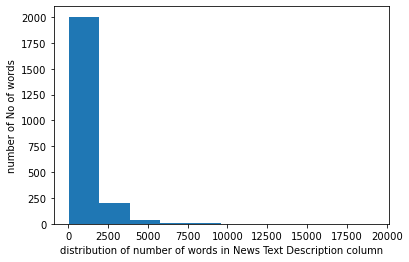

In [65]:
# No of words in each news descriptions or row
plt.hist(number_of_keywords)
plt.xlabel('distribution of number of words in News Text Description column')
plt.ylabel('number of No of words')
plt.show()

In [66]:
# convert to numpy array so that further processing will be easy.

keywords_array = clean_english_content['text_description'].to_numpy()

In [67]:
# Get the stopwords from NLTK library and punctuation from string 
# stopwords and punctuation will be removed from the text description so that it
#gives  how the important words are distributed in corpus


stops = stopwords.words("english")
punc = string.punctuation

In [68]:
# create a function to remove the stopwords and punctuation
# 1. convert sentence to lower case
# 2. split the sentnece to words at Space
# 3.remove the stop words and punctuation
# 4.append the words to wordlist and it returns the wordlist



def preprocess(keywords_array):
    words_list = []
    for keyword in keywords_array:
        splitted_words = keyword.lower().split()
        splitted_words = [word for word in splitted_words if word not in stops and word not in string.punctuation  ]
        words_list.append(splitted_words)
    return words_list

In [69]:
words_list = preprocess(keywords_array) # perform the function call with all the keywords array

In [70]:
len(words_list) # no of rows in wordlist

2264

In [71]:
# words_list[0] # Check individual words how it appeares

In [72]:
# Crete a Gensim Dictionary of wordlist
# It assigns each tokens to ID
dictionary = Dictionary(words_list) 

In [73]:
len(dictionary) # No of Unique tokens

112985

In [74]:
# Check Total no of words in entir corpus
number_words = 0
for word in words_list:
    number_words = number_words + len(word)

In [75]:
number_words 

1308443

In [76]:
dictionary.get(1000) # check random ID corresponding to a token in dictionary

'project.'

In [77]:
# Convert each word to Bag of Word model 

corpus = [dictionary.doc2bow(doc) for doc in words_list] 

In [78]:
## Convert the above output to TF IDF Model

tfidf = TfidfModel(corpus)

In [79]:
# tfidf[corpus[0]]

In [80]:
# Create a similarity matrix
#  Cosine similarity is one of the ways to measure the similarity of two vectors
# Genim uses it as default

sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [81]:
print(sims)

MatrixSimilarity<2264 docs, 112985 features>


- __The similarity matrix has 2264 no of rows and 112985 no of features.__

In [82]:
np.sort(sims.index[0])

array([0.        , 0.        , 0.        , ..., 0.21479188, 0.24243058,
       0.66375315], dtype=float32)

In [83]:
clean_english_content["text_description"].loc[15]

"Industrial adoption of IoT dubbed as Industrial Internet of Things (IIoT) is on ascend. Yet, near-term adoption of IIoT remains limited to achieving operational efficiency as most companies are unable to leverage IIoT for predictive capabilities that create new business opportunity. This article sheds light on the probable future of IIoT adoption and the imperative for businesses to form IIoT investment strategies. During Digital India Week in July, Prime Minister Modi announced the creation of a Centre of Excellence for Internet of Things. This is a timely intervention, as the Internet of Things, or IoT, will is set to transform technological and economic landscape over the next decade. The IoT will directly alter the Indian economy's industrial sectors, including manufacturing, energy, agriculture and transportation Together, these sectors account for close to half of India's GDP. It will also affect India's consumers, as their everyday devices connect to the Internet through tiny e

In [84]:
# All  above steps are combined to a function 
# 1. get the line from input item id\
# 2. preproces the text
# 3. convert text to Bag Of Word Model
# 4. #convert the regular bag of words model to a tf-idf model
# 5 . get the array of similarity values between item id and all other items in the dataset
# 6. Convert the similairty matrix to a Series and sort it.
# 7. returns the sorted similarity output.

def news_recommendation(item_id):
    news = clean_english_content.loc[english_content.item_index==item_id]["text_description"] # get the news row
    #preprocessing of text description
    keywords = preprocess(news) #get the words as a Series 
   
    query_doc = keywords #set the query_doc to the list of keywords
    
    query_doc_bow = [dictionary.doc2bow(doc) for doc in query_doc] # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model 
    #where we have tuples of words and it's tf-idf value for the news descriptions

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values 
    #between one News item Text with other News item Text. 
   

    similarity_series = pd.Series(similarity_array.tolist()[0],index=clean_english_content.item_index.values)
    similarity_output = similarity_series.sort_values(ascending=False) #Sort the similarity values
    return similarity_output 


In [85]:
#Recommended 10 news items for item index 1894
item = 1894
content_output_news = news_recommendation(item)
content_output_news[:11]

1894    1.000000
1192    0.243433
983     0.227312
1050    0.222530
2211    0.221113
58      0.207651
209     0.199654
1700    0.189633
472     0.186472
911     0.173447
1793    0.170582
dtype: float64

In [86]:
content_output_news.shape

(2264,)

In [87]:
# Create a DataFrame of the Output
news_content_df = pd.DataFrame(content_output_news[:11]).reset_index()
news_content_df.columns= ["item_index","score"]
news_content_df

,item_index,score
0,1894,1.000000
1,1192,0.243433
2,983,0.227312
3,1050,0.222530
4,2211,0.221113
5,58,0.207651
6,209,0.199654
7,1700,0.189633
8,472,0.186472
9,911,0.173447


### Top 10 prediction on Content Based Filtering:

In [88]:
# Merge the output dataframe with news content dataset to get the title
pd.merge(news_content_df,clean_english_content,on="item_index",how="left")

,item_index,score,title,text_description
0,1894,1.000000,IBM Watson is about to make Slack's chat bot s...,Slack's attempts at small talk are about to ge...
1,1192,0.243433,Slack and Google announce partnership focused ...,Slack announced a strategic partnership with G...
2,983,0.227312,How people using Slack to organise their groce...,When Cal Henderson began working on real-time ...
3,1050,0.222530,Introducing Sign in with Slack - Slack Platfor...,"Introducing Sign in with Slack Today, we're in..."
4,2211,0.221113,Threaded messaging is coming to Slack,"In an interview with Walt Mossberg, Slack CEO ..."
5,58,0.207651,Facebook Workplace officially launches on the ...,Facebook today officially announced the releas...
6,209,0.199654,Building on Slack Saved Our Startup,"From the start, we did everything right with T..."
7,1700,0.189633,IBM makes a big shift into cognitive computing,IBM's California research lab sits atop a gree...
8,472,0.186472,Slack debuts message buttons: bots with Trello...,"Slack, the communication and collaboration pla..."
9,911,0.173447,Slack and Uber's parting proves when apps unit...,What happens when two darlings of the American...


- __The 1st column is the item index of 10 similar news items when compared to item index 1894.__ 
- __The 2nd column is the similarity score with news item index 1894.__


## Collaboratve Filtering :
- Works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.
- It looks at the items they like and combines them to create a ranked list of suggestions.
- Collaborative filtering mostly categorize into -
  - Memory based CF.
  - Model Based CF.
- Memory based is again divided into -
    - User based CF.
    - Item based CF.

### User Based Recommendation :
- This is based on the simple premise that what a user is more likely to prefer,
 is highly correlated to what the other users similar to him/her have liked in the past.

-  __In User based recommendation, we will be working on Consumer dataset__

In [89]:

consumer.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,consumer_index,ratings,item_index
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,33,1,933
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,831,1,2933
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,826,1,1537
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,974,5,1537
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,887,1,246


In [90]:
# remove the unwanted column and create a new dataframe with Consumer index,item index and ratings
clean_consumer = consumer.iloc[:,[8,10,9]]

In [91]:
clean_consumer.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


In [92]:
# check the shape
clean_consumer.shape

(72312, 3)

In [93]:
# check the no of unique items
n_items = clean_consumer.item_index.nunique()

# check the no of unique consusmers
n_users = clean_consumer.consumer_index.nunique()
print(f"No of  unique Items: {n_items}" )
print(f"No of  unique Users: {n_users}")

No of  unique Items: 2987
No of  unique Users: 1895


### Train Test Split:

In [94]:
# Split the complete datset to Train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(clean_consumer, test_size=0.30, random_state=42)

### Create Empty data matrix  with User and News Item

In [95]:
# create training empty matrix and later fill the matrix with user, items, and ratings
# each row represents a user, whereas the columns correspond to different items.

data_matrix_train = np.zeros((n_users, n_items))

In [96]:
data_matrix_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
data_matrix_train.shape #check matrix shape

(1895, 2987)

In [98]:
train.shape

(50618, 3)

In [99]:
#fill the matrix with training data
#each row index represent user and and column index represent items and values represent ratings
for line in train.itertuples():
#     print(line[1]-1,line[2]-1,line[3])
#     break
    data_matrix_train[line[1]-1, line[2]-1] = line[3]

In [100]:
data_matrix_train.shape

(1895, 2987)

In [101]:
data_matrix_train.nonzero()

(array([   0,    0,    0, ..., 1894, 1894, 1894]),
 array([1153, 1321, 1765, ..., 2834, 2835, 2945]))

In [102]:
data_matrix_test = np.zeros((n_users, n_items))

In [103]:
#fill the matrix with test data
#each row index represent user and and column index represent items and values represent ratings
for line in test.itertuples():
#     print(line[1]-1,line[2]-1,line[3])
#     break
    data_matrix_test[line[1]-1, line[2]-1] = line[3]

In [104]:
data_matrix_test.shape

(1895, 2987)

In [105]:
data_matrix_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
data_matrix_full = np.zeros((n_users, n_items))

In [107]:
#fill the matrix with all consumer data
#each row index represent user and and column index represent items and values represent ratings

for line in clean_consumer.itertuples():
    data_matrix_full[line[1]-1, line[2]-1] = line[3]

In [108]:
data_matrix_full

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
# data_matrix_all = pd.pivot_table(clean_consumer,index="consumer_index",columns="item_index",values="ratings").fillna(0)

### User Based collaborative filtering:

#### Get User Similarity by calculating pairwise distances.

In [110]:
# Calculate user similarity with cosine distance 
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = 1- pairwise_distances(data_matrix_train, metric='cosine')

In [111]:
user_similarity[(user_similarity<1) & (user_similarity!=0)]

array([0.10910895, 0.02065041, 0.07968191, ..., 0.04688072, 0.04688072,
       0.02999813])

In [112]:
user_similarity.shape # No of users are 1895

(1895, 1895)

In [113]:
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.15384615, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.1069045 ],
       ...,
       [0.        , 0.15384615, 0.        , ..., 1.        , 0.        ,
        0.04688072],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.02999813],
       [0.        , 0.        , 0.1069045 , ..., 0.04688072, 0.02999813,
        1.        ]])

### Item based Collaborative Filtering :

#### Get Item Similarity by calculating pairwise distances:

In [114]:
# Calculate the cosine item similarity by taking transpose of data matrix train 
item_similarity = 1-pairwise_distances(data_matrix_train.T, metric='cosine')
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.06163336, ..., 0.08399211, 0.        ,
        0.        ],
       [0.        , 0.06163336, 1.        , ..., 0.17471414, 0.        ,
        0.05661385],
       ...,
       [0.        , 0.08399211, 0.17471414, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.05661385, ..., 0.        , 0.        ,
        1.        ]])

In [115]:
item_similarity.shape # No of items are 2987

(2987, 2987)

In [116]:
user_similarity.shape

(1895, 1895)

### Dot product of Data Matrix with similarity matrix

- We have calculated users and nw items pairwise by using similarity distance based on the cosine similarity measure.
- The dot product of the data matrix with this similarity matrix gave all the predicted ratings for the news items.
- Finally,we have used these predictions to recommend the top ten new items for consumer index 76.

In [117]:
# Get the item prediction taking dot product of user similarity and test data matrix
item_prediction = np.dot(user_similarity,data_matrix_test)

In [118]:
item_prediction

array([[0.62057454, 0.07112096, 0.30950479, ..., 0.24053081, 0.        ,
        0.11399657],
       [3.29056256, 0.08054275, 0.42022854, ..., 0.06052275, 0.        ,
        0.0410889 ],
       [0.048795  , 0.10724958, 0.07948031, ..., 0.04323377, 0.        ,
        0.34754887],
       ...,
       [0.35685561, 0.35476435, 0.6354166 , ..., 0.24827113, 0.        ,
        0.14633119],
       [0.15160347, 0.56426279, 0.80650212, ..., 0.39841756, 0.00800102,
        0.11168594],
       [0.24468843, 0.39819056, 0.82855359, ..., 0.58208307, 0.09144599,
        0.83597831]])

In [119]:
item_prediction.shape  # check the item prediction shape

(1895, 2987)

In [120]:
user_similarity.shape

(1895, 1895)

In [121]:
# Create  a Item prediction dataframe for ease of interpretations
prediction_df = pd.DataFrame(item_prediction) 

In [122]:
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,0.620575,0.071121,0.309505,0.0,0.133500,0.0,0.066026,0.119523,0.000000,0.153990,...,0.102276,0.037526,0.028499,0.058398,0.012218,0.067035,0.127418,0.240531,0.000000,0.113997
1,3.290563,0.080543,0.420229,0.0,0.140258,0.0,0.223216,0.000000,0.090515,0.054656,...,0.053201,0.000000,0.020544,0.028569,0.017931,0.135295,0.000000,0.060523,0.000000,0.041089
2,0.048795,0.107250,0.079480,0.0,0.000000,0.0,0.082545,0.000000,0.051602,0.000000,...,0.073723,0.079277,0.146343,0.000000,0.030667,0.092915,0.239766,0.043234,0.000000,0.347549
3,0.000000,0.444556,0.161440,0.0,0.176895,0.0,0.000000,0.023570,0.000000,0.084744,...,0.000000,0.000000,0.034816,0.000000,0.014456,0.034100,0.015881,0.061142,0.040324,0.034816
4,0.158114,0.106075,0.297068,0.0,0.115453,0.0,0.008886,0.018634,0.000000,0.018634,...,0.038072,0.048925,0.008886,0.036418,0.070354,0.132026,0.127301,0.370559,0.000000,0.035545


### Get recommended News item for consumer index 1893

In [123]:
prediction_df.iloc[1893]

0       0.151603
1       0.564263
2       0.806502
3       0.000000
4       0.400698
          ...   
2982    0.325217
2983    0.098948
2984    0.398418
2985    0.008001
2986    0.111686
Name: 1893, Length: 2987, dtype: float64

### Get top 10 Prediction of Consumer Index 1893

In [124]:
prediction_df.iloc[1893].sort_values(ascending=False)[:10]

2695    6.318163
2860    6.000987
1976    4.258427
2675    3.335756
2070    3.190483
416     3.178863
1714    3.011950
1848    2.937371
508     2.905792
1479    2.856870
Name: 1893, dtype: float64

In [125]:
l1 = prediction_df.iloc[1893].sort_values(ascending=False)[:10]

In [126]:
# Create an DataFrame of prediction content
recommended_news_df = pd.DataFrame(prediction_df.iloc[1893].sort_values(ascending=False))

In [127]:
recommended_news_df

,1893
2695,6.318163
2860,6.000987
1976,4.258427
2675,3.335756
2070,3.190483
...,...
1352,0.000000
1966,0.000000
1970,0.000000
1971,0.000000


In [128]:
# reset the index so that the index should appear uniformly.
recommended_news_df.reset_index(inplace=True)

In [129]:
recommended_news_df.head()

,index,1893
0,2695,6.318163
1,2860,6.000987
2,1976,4.258427
3,2675,3.335756
4,2070,3.190483


In [130]:
# assign the columns names
recommended_news_df.columns = ["item_index","score"] 

In [131]:
recommended_news_df.head()

,item_index,score
0,2695,6.318163
1,2860,6.000987
2,1976,4.258427
3,2675,3.335756
4,2070,3.190483


###  Get the prediction with News title:

In [132]:
# merge with content data

merged_user_based = pd.merge(recommended_news_df,clean_english_content,on="item_index",how="left")

In [133]:
# few of the item index in consumer data is not available in content data.
# Hence we get NaN after merge and dropped those NaN 

merged_user_based.dropna(inplace=True)
merged_user_based

,item_index,score,title,text_description
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ..."
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...
...,...,...,...,...
3028,1352,0.000000,Thorium,"On September 12, 1932, a man named Leo Szilard..."
3029,1966,0.000000,Announcing .NET Core 1.0,We are excited to announce the release of .NET...
3030,1970,0.000000,Self-Driving Cars and Insurance,THE TOPIC Each new generation of cars is equip...
3031,1971,0.000000,The Gold Mine: A Novel of Lean Turnaround,"Format: Paperback Just in time for summer, the..."


### Top 10 prediction on User Based CF

In [134]:
# Top 10 prediction on User Bases CF
merged_user_based.head(10)

,item_index,score,title,text_description
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ..."
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...
8,508,2.905792,Globant Recognized as a Worldwide Leader of Di...,"SAN FRANCISCO, June 14, 2016 /PRNewswire/ -- G..."
9,1479,2.856870,How will bots make money? Here are 7 business ...,Another bot (hot damn) Called a police and a f...
10,846,2.765620,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...
11,1595,2.740285,The future of agriculture - Jim Womack visits ...,WOMACK'S YOKOTEN - Lean in agriculture might s...
12,542,2.728393,Google lags behind Amazon and Microsoft's clou...,Thomson Reuters Google's cloud service may wan...


### Normalized the Score:

In [135]:
# pefrom min max normalization
merged_user_based["normalized_score"] = (merged_user_based["score"] - merged_user_based["score"].min())/(merged_user_based["score"].max()- merged_user_based["score"].min())

In [136]:
merged_user_based.head(10)

,item_index,score,title,text_description,normalized_score
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...,1.000000
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...,0.749216
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...,0.746488
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ...",0.707292
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...,0.689778
8,508,2.905792,Globant Recognized as a Worldwide Leader of Di...,"SAN FRANCISCO, June 14, 2016 /PRNewswire/ -- G...",0.682363
9,1479,2.856870,How will bots make money? Here are 7 business ...,Another bot (hot damn) Called a police and a f...,0.670875
10,846,2.765620,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...,0.649446
11,1595,2.740285,The future of agriculture - Jim Womack visits ...,WOMACK'S YOKOTEN - Lean in agriculture might s...,0.643497
12,542,2.728393,Google lags behind Amazon and Microsoft's clou...,Thomson Reuters Google's cloud service may wan...,0.640705


### Performance Evaluation on User based Collabortive Filtering:
-  MAE
- RMSE

In [137]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from math import sqrt

- __if we need to compare all ratings data for evaluation:
then the evaluation metrics should be RMSE or MAE.__
- __else in case of Top N rankings data:
we need  Precision@K, MAP@K etc for evaluation.__

### Mean Absolute Error(MAE):

In [138]:
# MAE is the absolute difference between the actual and predicted values
# divided by the total number of observations.

# define an function mae which takes the predicted data and actual data(groundtruth)
def mae(prediction,ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return mean_absolute_error(prediction,ground_truth)

In [139]:
# call the function mae
mae(item_prediction,data_matrix_test)

1.2301490167425138

### Root mean squared error(RMSE)

In [140]:
# output (a predicted scalar value) is compared with the true scalar value output for a given data point

#define rmse function which takes the predicted data and actual data(groundtruth)
def rmse(prediction,ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction,ground_truth))

In [141]:
rmse(item_prediction,data_matrix_test)

1.9074554632780087

- __we can not always rely on offline evaluation like above.__
- __We have to check online evaluation aswell like human level performance on the recommendation eveluation.__

##  Model-Based CF

- Model-based collaborative filtering algorithms provide item recommendations by first developing a model of user ratings.  - The recommendations can be made using the deterministic algorithms like ALS.
- ALS is Alternating Least Squares


## Alternating Least Squares(ALS)

### Create Sparse User-Item Matrix
- __will create a compressed sparse row matrix for user-item and item-user combinations.__ 
- __This helps in extracting only the non-zero user-items combinations interacted by the user.__

In [142]:
from scipy.sparse import csr_matrix

In [143]:
alpha=40 # assign an random value 


In [144]:
clean_consumer.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


In [145]:
clean_consumer.shape[0]

72312

In [146]:
clean_consumer.shape

(72312, 3)

In [147]:
clean_consumer.describe()


,consumer_index,item_index,ratings
count,72312.000000,72312.000000,72312.000000
mean,945.367491,1485.004508,1.292234
std,514.935478,856.146451,0.801325
min,0.000000,0.000000,1.000000
25%,588.000000,740.000000,1.000000
50%,926.000000,1491.000000,1.000000
75%,1338.250000,2194.000000,1.000000
max,1894.000000,2986.000000,5.000000


#### create a compressed sparse row matrix for user-item

In [148]:
sparse_user_item = csr_matrix( ([alpha]*clean_consumer.shape[0], (clean_consumer['consumer_index'], clean_consumer['item_index']) ))

In [149]:
sparse_user_item # display

<1895x2987 sparse matrix of type '<class 'numpy.int64'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [150]:
sparse_user_item.shape # Check the shape (Users,items)

(1895, 2987)

In [151]:
csr_user_array = sparse_user_item.toarray() # convert to numpy array

In [152]:
csr_user_array

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 80,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [153]:
csr_user_array.shape

(1895, 2987)

In [154]:
print(sparse_user_item)

  (0, 65)	40
  (0, 160)	40
  (0, 188)	40
  (0, 196)	40
  (0, 314)	320
  (0, 328)	40
  (0, 386)	40
  (0, 417)	40
  (0, 443)	40
  (0, 451)	80
  (0, 453)	80
  (0, 465)	40
  (0, 570)	40
  (0, 702)	80
  (0, 769)	40
  (0, 813)	40
  (0, 819)	80
  (0, 864)	40
  (0, 890)	40
  (0, 1087)	80
  (0, 1358)	40
  (0, 1390)	80
  (0, 1411)	120
  (0, 1618)	40
  (0, 1632)	40
  :	:
  (1894, 1977)	160
  (1894, 2023)	40
  (1894, 2027)	40
  (1894, 2071)	640
  (1894, 2080)	80
  (1894, 2190)	40
  (1894, 2253)	80
  (1894, 2334)	40
  (1894, 2349)	40
  (1894, 2451)	40
  (1894, 2470)	40
  (1894, 2538)	80
  (1894, 2608)	40
  (1894, 2676)	80
  (1894, 2696)	120
  (1894, 2719)	40
  (1894, 2772)	80
  (1894, 2809)	40
  (1894, 2814)	80
  (1894, 2845)	40
  (1894, 2861)	160
  (1894, 2867)	40
  (1894, 2922)	40
  (1894, 2925)	40
  (1894, 2981)	40


### Create Item User Sparse Matrix

In [155]:
sparse_item_user = sparse_user_item.T.tocsr() # take a traspose to convert user_item to item_user

In [156]:
sparse_item_user

<2987x1895 sparse matrix of type '<class 'numpy.int64'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [157]:
csr_item_array = sparse_item_user.toarray()
csr_item_array.shape

(2987, 1895)

In [158]:
# !pip install implicit

In [159]:
import implicit
from implicit.evaluation import train_test_split

### Train Test split of sparse_item_user matrix

In [160]:
# divided the dataset using the train-test split
train_als, test_als = train_test_split(sparse_item_user, train_percentage=0.8)

In [161]:
train_als

<2987x1895 sparse matrix of type '<class 'numpy.int64'>'
	with 32521 stored elements in Compressed Sparse Row format>

In [162]:
test_als

<2987x1895 sparse matrix of type '<class 'numpy.int64'>'
	with 8189 stored elements in Compressed Sparse Row format>

### Building ALS Model

#### Hyperparameters:
- __Factors - Length of feature factor.__
- __Regularization Parameter -  to control overfitting.__
- __iterations -  No of iterations to build  a final model.__
- __calculate_training_loss -  Calculate training loss for each itertions.__

In [163]:
# Build the ALS Model
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20,calculate_training_loss=False)


In [164]:
model

In [165]:
# Train the model with training data
model.fit(train_als)

  0%|          | 0/20 [00:00<?, ?it/s]

In [166]:
# Get an random Consumer Index 
user_id = 623

In [167]:
# Recommend the News Items for Consumer Index
# Default it gives 10 recomendation

model.recommend(user_id,sparse_user_item)

[(754, 0.7036911),
 (826, 0.6339026),
 (55, 0.58492434),
 (2875, 0.5835147),
 (1211, 0.56666493),
 (1268, 0.55584395),
 (664, 0.55260885),
 (2638, 0.5383167),
 (609, 0.53708607),
 (2412, 0.5328288)]

In [168]:
 # N is the no of recommendation we want
    
model.recommend(user_id,sparse_user_item,N=30)

[(754, 0.7036911),
 (826, 0.6339026),
 (55, 0.58492434),
 (2875, 0.5835147),
 (1211, 0.56666493),
 (1268, 0.55584395),
 (664, 0.55260885),
 (2638, 0.5383167),
 (609, 0.53708607),
 (2412, 0.5328288),
 (535, 0.52361864),
 (2440, 0.51160467),
 (1055, 0.5070273),
 (700, 0.5010472),
 (950, 0.48987892),
 (1887, 0.47482514),
 (2013, 0.47394753),
 (454, 0.46984607),
 (2272, 0.46851504),
 (420, 0.456509),
 (584, 0.45318687),
 (745, 0.43116957),
 (856, 0.4116362),
 (282, 0.40733135),
 (185, 0.39929762),
 (583, 0.39908725),
 (2688, 0.39757288),
 (2330, 0.38947108),
 (2109, 0.38394642),
 (1653, 0.38166118)]

In [169]:
# predict the items  with als score 
output_als = model.recommend(user_id,sparse_user_item)

In [170]:
# Create a DataFrame of output_als
output_df = pd.DataFrame(output_als,columns=["item_index","als_score"])

In [171]:
output_df # check the dataframe

,item_index,als_score
0,754,0.703691
1,826,0.633903
2,55,0.584924
3,2875,0.583515
4,1211,0.566665
5,1268,0.555844
6,664,0.552609
7,2638,0.538317
8,609,0.537086
9,2412,0.532829


### Get the "title" of predicted item index from content table for ease of understanding 

In [172]:
# get the filtered item index
# predicted_title = english_content[english_content['item_index'].isin(output_df.item_index.values)]["title"].values
merged_als = pd.merge(output_df,english_content,on="item_index",how="left")
merged_als = merged_als[["item_index","als_score","title"]].dropna().reset_index(drop=True)
merged_als


,item_index,als_score,title
0,754,0.703691,The Secret History of Agile Innovation
1,754,0.703691,The Secret History of Agile Innovation
2,754,0.703691,The Secret History of Agile Innovation
3,826,0.633903,Announcing the Acquia Engage Awards
4,55,0.584924,How HTTP/2 is Changing Web Performance Best Pr...
5,1211,0.566665,Google Calendar for Android can now find meeti...
6,1268,0.555844,New Amazon Linux Container Image for Cloud and...
7,664,0.552609,Warcraft fans' fury at Blizzard over server cl...
8,609,0.537086,Google acquires deep search engine Kifi to enh...


### Normalized the ALS Score

In [173]:
# min max normalization 
merged_als["normalized_als_score"] =  (merged_als["als_score"] - merged_als["als_score"].min())/(merged_als["als_score"].max()- merged_als["als_score"].min())

### Top 10 Prediction for Consumer ID 623 via ALS based Recommendation

In [174]:
merged_als.head(10)

,item_index,als_score,title,normalized_als_score
0,754,0.703691,The Secret History of Agile Innovation,1.000000
1,754,0.703691,The Secret History of Agile Innovation,1.000000
2,754,0.703691,The Secret History of Agile Innovation,1.000000
3,826,0.633903,Announcing the Acquia Engage Awards,0.581114
4,55,0.584924,How HTTP/2 is Changing Web Performance Best Pr...,0.287136
5,1211,0.566665,Google Calendar for Android can now find meeti...,0.177539
6,1268,0.555844,New Amazon Linux Container Image for Cloud and...,0.112589
7,664,0.552609,Warcraft fans' fury at Blizzard over server cl...,0.093171
8,609,0.537086,Google acquires deep search engine Kifi to enh...,0.000000


### Top 10 Similar Users like Consumer ID 623

In [175]:
# Check the similar users like user index 623
model.similar_users(623)[1:11]

[(1139, 0.5777367),
 (329, 0.56057173),
 (1023, 0.5557863),
 (1350, 0.5241059),
 (1889, 0.52281016),
 (954, 0.52281016),
 (1702, 0.48294806),
 (563, 0.4742522),
 (767, 0.47014004)]

In [176]:
## Find the similar items for item id 1894

similar_items_als = model.similar_items(1894)

In [177]:
# create the dataframe from the similar items

similar_items_als_df = pd.DataFrame(similar_items_als, columns=['item_index', 'score'])
similar_items_als_df

,item_index,score
0,1894,1.000000
1,891,0.588582
2,2675,0.508284
3,882,0.483759
4,1294,0.442981
5,2171,0.387069
6,1139,0.365107
7,177,0.345415
8,2185,0.344542
9,881,0.339016


### Merge with content data to get news title:

In [178]:
# merged the similar items and content 
merged_similar_items_als = pd.merge(similar_items_als_df, clean_english_content, how='left', on='item_index')
merged_similar_items_als

,item_index,score,title,text_description
0,1894,1.000000,IBM Watson is about to make Slack's chat bot s...,Slack's attempts at small talk are about to ge...
1,891,0.588582,Google's OnHub router finally gets some smart ...,Google's OnHub router just got a major new fea...
2,2675,0.508284,NaN,NaN
3,882,0.483759,[Videos] Bill Gross: The single biggest reason...,You have JavaScript disabled Bill Gross has fo...
4,1294,0.442981,Hype Driven Development,Software development teams often make decision...
5,2171,0.387069,Configuring OSGi,"For run mode specific configurations, multiple..."
6,1139,0.365107,Research: Why Best Practices Don't Translate A...,It made sense. A large high-technology company...
7,177,0.345415,How This Googler Redesigned The Workweek,Jake Knapp has always been concerned about the...
8,2185,0.344542,How big is the Google Earth database? - Google...,This is the fourth and final in a series of po...
9,881,0.339016,When Will The First Machine Become Superintell...,When Will The First Machine Become Superintell...


### TOP 10 similar items for News Index 1894 via ALS

In [179]:
merged_similar_items_als.head(10) # check the dataframe

,item_index,score,title,text_description
0,1894,1.000000,IBM Watson is about to make Slack's chat bot s...,Slack's attempts at small talk are about to ge...
1,891,0.588582,Google's OnHub router finally gets some smart ...,Google's OnHub router just got a major new fea...
2,2675,0.508284,NaN,NaN
3,882,0.483759,[Videos] Bill Gross: The single biggest reason...,You have JavaScript disabled Bill Gross has fo...
4,1294,0.442981,Hype Driven Development,Software development teams often make decision...
5,2171,0.387069,Configuring OSGi,"For run mode specific configurations, multiple..."
6,1139,0.365107,Research: Why Best Practices Don't Translate A...,It made sense. A large high-technology company...
7,177,0.345415,How This Googler Redesigned The Workweek,Jake Knapp has always been concerned about the...
8,2185,0.344542,How big is the Google Earth database? - Google...,This is the fourth and final in a series of po...
9,881,0.339016,When Will The First Machine Become Superintell...,When Will The First Machine Become Superintell...


In [180]:
## NaN appeares because the Cosnumer Data has item index which is not available in Content Dataset.
## Hence Title and Text description has  NaN 

In [181]:
# from implicit.evaluation import precision_at_k
# p = precision_at_k(model, train.tocsr(), test.tocsr(), K=10)

In [182]:
# check the all similar items like by passing item index 1894
model.similar_items(1894,2987)

[(1894, 1.0000001),
 (891, 0.5885817),
 (2675, 0.50828373),
 (882, 0.48375893),
 (1294, 0.44298056),
 (2171, 0.38706857),
 (1139, 0.36510655),
 (177, 0.34541452),
 (2185, 0.3445419),
 (881, 0.33901563),
 (2927, 0.31981966),
 (153, 0.3198121),
 (1531, 0.3184213),
 (1239, 0.30739),
 (1090, 0.29661396),
 (433, 0.2889315),
 (105, 0.28655428),
 (2576, 0.28648975),
 (2917, 0.28363338),
 (2890, 0.28292024),
 (2942, 0.27885756),
 (1960, 0.27716237),
 (573, 0.27441064),
 (770, 0.27316803),
 (136, 0.27252522),
 (2085, 0.26844501),
 (1216, 0.26638186),
 (1792, 0.26511502),
 (2915, 0.26421),
 (428, 0.264061),
 (2315, 0.26319504),
 (605, 0.2620474),
 (671, 0.2613762),
 (2158, 0.25985068),
 (350, 0.25516897),
 (1398, 0.24998677),
 (1602, 0.24843784),
 (109, 0.2482117),
 (2384, 0.24578857),
 (1946, 0.24434233),
 (1409, 0.24203268),
 (2912, 0.24177673),
 (788, 0.24102429),
 (104, 0.23996492),
 (1498, 0.23937131),
 (2068, 0.23878069),
 (2938, 0.23828846),
 (2033, 0.23794338),
 (1873, 0.23702098),
 (785

## Hybrid Recommendation 

- A hybrid recommender system is a combination of different recommendation models.
- hybrid recommendation systems are a combination of both content and collaborative models. 
- The features of both models are combined to enhance the quality of recommendations made to a user.

In [183]:
clean_consumer.shape

(72312, 3)

In [184]:
clean_consumer.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


### Item based CF:

In [185]:
# Create a pivot matirx from consumer data

data_matrix_hybrid = pd.pivot_table(clean_consumer,
                                    index="consumer_index",
                                    columns="item_index",
                                    values="ratings").fillna(0)

In [186]:
data_matrix_hybrid.head()

item_index,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
consumer_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
data_matrix_hybrid.shape # Check the shape

(1895, 2987)

In [188]:
data_matrix_hybrid.T.shape # Get the transpose of data matrix 

(2987, 1895)

### Item Based Similarity

In [189]:
from sklearn.metrics.pairwise import pairwise_distances 

In [190]:
# Calculate the item similarity by taking a transpose of user item matrix
item_similarity = 1- pairwise_distances(data_matrix_hybrid.T, metric='cosine')

In [191]:
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.33068092, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.06716158,
        0.08061138],
       ...,
       [0.33068092, 0.        , 0.        , ..., 1.        , 0.06174613,
        0.14822286],
       [0.        , 0.        , 0.06716158, ..., 0.06174613, 1.        ,
        0.08331525],
       [0.        , 0.        , 0.08061138, ..., 0.14822286, 0.08331525,
        1.        ]])

In [192]:
item_similarity.shape # Check the shape

(2987, 2987)

### Get similar recommended news for a news ID

In [193]:
news_index = 819

In [194]:
#Create a data frame by tking item similarity matrix.
news_prediction = pd.DataFrame(item_similarity)

In [195]:
news_prediction

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,1.000000,0.0,0.000000,0.117469,0.168773,0.000000,0.0,0.286817,0.000000,0.000000,...,0.331998,0.237357,0.000000,0.629921,0.000000,0.000000,0.000000,0.330681,0.000000,0.000000
1,0.000000,1.0,0.000000,0.000000,0.000000,0.040093,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,1.000000,0.123798,0.000000,0.097025,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.127458,0.342005,0.083122,0.000000,0.067162,0.080611
3,0.117469,0.0,0.123798,1.000000,0.000000,0.098583,0.0,0.107369,0.137361,0.118958,...,0.000000,0.194954,0.097129,0.092144,0.259010,0.086874,0.063343,0.165033,0.179131,0.000000
4,0.168773,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.161608,0.000000,0.204598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,0.000000,0.0,0.342005,0.086874,0.000000,0.113478,0.0,0.058161,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.074536,1.000000,0.072913,0.000000,0.058913,0.000000
2983,0.000000,0.0,0.083122,0.063343,0.000000,0.227536,0.0,0.212034,0.000000,0.199681,...,0.000000,0.335973,0.415749,0.000000,0.054346,0.072913,1.000000,0.251094,0.085910,0.103115
2984,0.330681,0.0,0.000000,0.165033,0.000000,0.000000,0.0,0.220972,0.000000,0.000000,...,0.000000,0.329281,0.284581,0.407613,0.000000,0.000000,0.251094,1.000000,0.061746,0.148223
2985,0.000000,0.0,0.067162,0.179131,0.000000,0.033427,0.0,0.034264,0.000000,0.000000,...,0.000000,0.049357,0.131733,0.000000,0.131733,0.058913,0.085910,0.061746,1.000000,0.083315


In [196]:
news_prediction.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,1.000000,0.000000,0.000000,0.117469,0.168773,0.000000,0.0,0.286817,0.000000,0.000000,...,0.331998,0.237357,0.000000,0.629921,0.000000,0.000000,0.000000,0.330681,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.040093,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.123798,0.000000,0.097025,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.127458,0.342005,0.083122,0.000000,0.067162,0.080611
3,0.117469,0.000000,0.123798,1.000000,0.000000,0.098583,0.0,0.107369,0.137361,0.118958,...,0.000000,0.194954,0.097129,0.092144,0.259010,0.086874,0.063343,0.165033,0.179131,0.000000
4,0.168773,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.161608,0.000000,0.204598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.040093,0.097025,0.098583,0.000000,1.000000,0.0,0.098999,0.000000,0.000000,...,0.000000,0.047535,0.063436,0.000000,0.169163,0.113478,0.227536,0.000000,0.033427,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.286817,0.000000,0.000000,0.107369,0.000000,0.098999,0.0,1.000000,0.000000,0.000000,...,0.078031,0.309761,0.195077,0.123377,0.000000,0.058161,0.212034,0.220972,0.034264,0.082252
8,0.000000,0.000000,0.000000,0.137361,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.235702,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.118958,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,0.000000,0.229439,0.102062,0.000000,0.000000,0.000000,0.199681,0.000000,0.000000,0.000000


In [197]:
# create an dataframe of predicted data
item_recommendation = pd.DataFrame(news_prediction.iloc[news_index].sort_values(ascending=False))

In [198]:
item_recommendation

,819
819,1.000000
620,0.524865
1500,0.522644
2537,0.492920
209,0.491697
...,...
808,0.000000
2059,0.000000
810,0.000000
2056,0.000000


In [199]:
item_recommendation.head()

,819
819,1.000000
620,0.524865
1500,0.522644
2537,0.492920
209,0.491697


In [200]:
# reset the index so that the index will be continuous
item_recommendation.reset_index(inplace=True)

In [201]:
item_recommendation.head()

,index,819
0,819,1.000000
1,620,0.524865
2,1500,0.522644
3,2537,0.492920
4,209,0.491697


In [202]:
item_recommendation.columns = ['item_index', 'score'] # assign columns names to DataFrame

In [203]:
item_recommendation.head()

,item_index,score
0,819,1.000000
1,620,0.524865
2,1500,0.522644
3,2537,0.492920
4,209,0.491697


### Merge news item id  with news title

In [204]:
# Check the shape of dataframe whih are to be merged
print(item_recommendation.shape)
print(clean_english_content.shape)

(2987, 2)
(2264, 3)


In [205]:
# Merge data frame  to get the Title and Title description
# take item index as key relation 
merged_item_based = pd.merge(item_recommendation, clean_english_content, on='item_index', how='inner')

In [206]:
merged_item_based.shape

(2264, 4)

In [207]:
merged_item_based.head() # Check  the data

,item_index,score,title,text_description
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...,As we take a look forward at what's new and wh...
1,620,0.524865,Game of Loans,As Queen-Mother Cersei undertook her walk of s...
2,1500,0.522644,"""It's time for self-directed 'smart' investing...",I recently had the chance to speak to Swanest ...
3,209,0.491697,Building on Slack Saved Our Startup,"From the start, we did everything right with T..."
4,1728,0.489476,Google employees are adding 'Lady' to their jo...,More than 800 members of Google's staff are st...


In [208]:
# display only required columns
merged_item_based[["item_index","score","title"]].head()

,item_index,score,title
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...
1,620,0.524865,Game of Loans
2,1500,0.522644,"""It's time for self-directed 'smart' investing..."
3,209,0.491697,Building on Slack Saved Our Startup
4,1728,0.489476,Google employees are adding 'Lady' to their jo...


In [209]:
# If incase any NaN values are there. just remove them
collab_output = merged_item_based[merged_item_based['title'].notna()] 

In [210]:
collab_output[["item_index","score","title"]].head() # check the head

,item_index,score,title
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...
1,620,0.524865,Game of Loans
2,1500,0.522644,"""It's time for self-directed 'smart' investing..."
3,209,0.491697,Building on Slack Saved Our Startup
4,1728,0.489476,Google employees are adding 'Lady' to their jo...


### Normalize the score, so that comparision will be easier

In [211]:
# min max normalization
collab_output['collaborative_score_normalized'] = (collab_output['score']-min(collab_output['score']))/(max(collab_output['score'])-min(collab_output['score']))

### Top 10 Recommendationb for Item Bases Collaborative Filtering

In [212]:
# Select only required columns
collab_output[["item_index","score","title","collaborative_score_normalized"]].head(10)

,item_index,score,title,collaborative_score_normalized
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...,1.000000
1,620,0.524865,Game of Loans,0.524865
2,1500,0.522644,"""It's time for self-directed 'smart' investing...",0.522644
3,209,0.491697,Building on Slack Saved Our Startup,0.491697
4,1728,0.489476,Google employees are adding 'Lady' to their jo...,0.489476
5,1589,0.480041,Do Crows Hold Funerals for Their Dead?,0.480041
6,468,0.470536,Coder | Drupal.org,0.470536
7,383,0.456016,"Cloud Shell now GA, and still free",0.456016
8,360,0.444244,8 Books Stanford MBAs Recommend You Read This ...,0.444244
9,1997,0.433920,This motorized wheel adds electric power to yo...,0.433920


### Precision@K
- precision is the measure of the actual number of items that a user likes out of all the recommendations

In [213]:
# get 10 predicted items
pred_set = merged_item_based["item_index"].values[:10]
pred_set

array([ 819,  620, 1500,  209, 1728, 1589,  468,  383,  360, 1997],
      dtype=int64)

In [214]:
# clean_consumer[clean_consumer["item_index"]==2394]

### Check precision of a Consumer Index:

In [215]:
consumer_index = 804

In [216]:
#  clean_consumer[(clean_consumer["ratings"]>=3)]

In [217]:
# Filter the items where the consumer has rated 3 or more than 3 to news items
ratings_filtered = clean_consumer[(clean_consumer["ratings"]>3) & (clean_consumer["consumer_index"]==consumer_index)]

In [218]:
ratings_filtered

,consumer_index,item_index,ratings
61,804,819,4
62,804,819,4
69,804,819,5
8465,804,620,4
27906,804,2539,4
34668,804,1686,5
34688,804,1686,4


In [219]:
relevant_set = ratings_filtered.item_index.values
relevant_set


array([ 819,  819,  819,  620, 2539, 1686, 1686], dtype=int64)

In [220]:
list(set(relevant_set) & set(pred_set))

[819, 620]

In [221]:
precision_at_10 = len(list(set(relevant_set) & set(pred_set)))/10

In [222]:
precision_at_10

0.2

- __For consumer_index = 804, the precision comes as 0.2, as the consumer has rated the item 819.__
- __if the consumer has not rated the item, then precision can be zero.__

### Global Average Precision @K

-  __Mean Average Precision at k (MAP@k): MAP@k is the average of precision at value from 1 to k where k is the number of recommendations.__


- __Global precision@k value which gives an overall idea of how the model is performing considering all the users with the predicted list containing relevant items for each of them.__

In [223]:
clean_consumer.consumer_index.nunique()

1895

In [224]:
# Calculate the global precision
global_precision = 0
for user_index in range(0,1895):
    user_relevant_set = clean_consumer[(clean_consumer["ratings"]>=3) & 
                                       (clean_consumer["consumer_index"]==user_index)].\
                                        sort_values(by="ratings",ascending=False)["item_index"].tolist()
    
    user_predicted_set = news_prediction.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()
    
    precision_at_10 = (len(list(set(user_relevant_set) & set(user_predicted_set))))/10
    
    if precision_at_10 !=0:  # filter where precision is zero 
        print(user_index,"--->", precision_at_10)
    global_precision = global_precision + precision_at_10

509 ---> 0.2
831 ---> 0.2
1114 ---> 0.1
1286 ---> 0.1
1379 ---> 0.1
1650 ---> 0.1
1884 ---> 0.1


In [225]:
global_precision

0.8999999999999999

In [226]:
# Calculate the Global Average Precision 
global_average_precision = global_precision/clean_consumer["consumer_index"].nunique()
global_average_precision

0.00047493403693931396

In [227]:
clean_consumer.head()

,consumer_index,item_index,ratings
0,33,933,1
1,831,2933,1
2,826,1537,1
3,974,1537,5
4,887,246,1


### Continue with the Content Recommendation prediction :
- This will be used in Hybrid recommendation model

In [228]:
type(content_output_news)

pandas.core.series.Series

In [229]:
# create a dataframe from content based model output
content_df = pd.DataFrame(content_output_news)

In [230]:
content_df.head()

,0
1894,1.000000
1192,0.243433
983,0.227312
1050,0.222530
2211,0.221113


In [231]:
# reset the index to make the index continuous
content_df.reset_index(inplace=True)

In [232]:
content_df.head()

,index,0
0,1894,1.000000
1,1192,0.243433
2,983,0.227312
3,1050,0.222530
4,2211,0.221113


In [233]:
# assign the column names to content prediction data
content_df.columns = ['item_index', 'score']

In [234]:
content_df.head()

,item_index,score
0,1894,1.000000
1,1192,0.243433
2,983,0.227312
3,1050,0.222530
4,2211,0.221113


### Normalize score
- Min Max normalization

In [235]:
content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))

In [236]:
content_df.head()

,item_index,score,content_score_normalized
0,1894,1.000000,1.000000
1,1192,0.243433,0.243433
2,983,0.227312,0.227312
3,1050,0.222530,0.222530
4,2211,0.221113,0.221113


In [237]:
# check the shape of dataframe content output
content_df.shape

(2264, 3)

In [238]:
# check the shape of dataframe collaborative output
collab_output.shape

(2264, 5)

### Hybrid: Combine two Models: Collaborative Item based output and Content based output

In [239]:
# merge with content data to get the title information and description 
hybrid_output = pd.merge(collab_output,content_df, how='left', on='item_index')

In [240]:
hybrid_output.head()

,item_index,score_x,title,text_description,collaborative_score_normalized,score_y,content_score_normalized
0,819,1.000000,Building A Better Workforce: 5 Talent Trends W...,As we take a look forward at what's new and wh...,1.000000,0.021054,0.021054
1,620,0.524865,Game of Loans,As Queen-Mother Cersei undertook her walk of s...,0.524865,0.003898,0.003898
2,1500,0.522644,"""It's time for self-directed 'smart' investing...",I recently had the chance to speak to Swanest ...,0.522644,0.017230,0.017230
3,209,0.491697,Building on Slack Saved Our Startup,"From the start, we did everything right with T...",0.491697,0.199654,0.199654
4,1728,0.489476,Google employees are adding 'Lady' to their jo...,More than 800 members of Google's staff are st...,0.489476,0.005730,0.005730


In [241]:
# show only the required columns
hybrid_output[["score_x","collaborative_score_normalized", "score_y", "content_score_normalized"]].head()

,score_x,collaborative_score_normalized,score_y,content_score_normalized
0,1.000000,1.000000,0.021054,0.021054
1,0.524865,0.524865,0.003898,0.003898
2,0.522644,0.522644,0.017230,0.017230
3,0.491697,0.491697,0.199654,0.199654
4,0.489476,0.489476,0.005730,0.005730


### Calculated the weighted average of two models:
- Here equal weight is given to both the models, hence became simple average.

In [242]:
# take average or mean value two columns
hybrid_output['final_score'] = (hybrid_output['collaborative_score_normalized'] + hybrid_output['content_score_normalized'])/2

In [243]:
# show only the required columns
hybrid_output[["item_index","score_x","collaborative_score_normalized", "score_y", "content_score_normalized","final_score"]]

,item_index,score_x,collaborative_score_normalized,score_y,content_score_normalized,final_score
0,819,1.000000,1.000000,0.021054,0.021054,0.510527
1,620,0.524865,0.524865,0.003898,0.003898,0.264381
2,1500,0.522644,0.522644,0.017230,0.017230,0.269937
3,209,0.491697,0.491697,0.199654,0.199654,0.345675
4,1728,0.489476,0.489476,0.005730,0.005730,0.247603
...,...,...,...,...,...,...
2353,808,0.000000,0.000000,0.002333,0.002333,0.001166
2354,2059,0.000000,0.000000,0.016774,0.016774,0.008387
2355,810,0.000000,0.000000,0.012796,0.012796,0.006398
2356,2056,0.000000,0.000000,0.004296,0.004296,0.002148


## Hybrid Model 2
### ALS User based + User based collaborative filtering:

In [244]:
## User Based Collaborative Filtering with User Index 623
## Create a dataframe from predicted data
## assign column names 
## combine with conent dataframe to get the title for easy interpretation
## perform the min max normalization

recommended_news_df1 = pd.DataFrame(prediction_df.iloc[623].sort_values(ascending=False))
recommended_news_df1.reset_index(inplace=True)
# recommended_news_df1.head()
recommended_news_df1.columns = ["item_index","score"]
merged_user_based1 = pd.merge(recommended_news_df1,clean_english_content,on="item_index",how="left")
merged_user_based1.dropna(inplace=True)
merged_user_based1
merged_user_based1["normalized_score"] = (merged_user_based1["score"] - merged_user_based1["score"].min())/(merged_user_based1["score"].max()- merged_user_based1["score"].min())

In [245]:
merged_user_based1.head()

,item_index,score,title,text_description,normalized_score
0,405,15.007504,"""We only hire the best"" - Signal v. Noise","""We only hire the best"" How many times have yo...",1.000000
3,846,4.382523,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...,0.292022
4,1452,4.316721,This is the scientific reason we're addicted t...,"Whether you're working in your office, walking...",0.287638
5,1267,4.312488,How a Japanese cucumber farmer is using deep l...,It's not hyperbole to say that use cases for m...,0.287355
7,771,2.932844,Serverless Architectures,Mike Roberts Mike is an engineering leader liv...,0.195425


#### Merge 2 dataframe:  User based CF and  ALS User Based:

In [246]:
# merge User based CF output and ALS usr based output
hybrid_output_als_user = pd.merge(merged_user_based1,merged_als, how='left', on='item_index').fillna(0)

In [247]:
# create the final score by taking mean of both the normalized score.
hybrid_output_als_user["final_score"] = (hybrid_output_als_user["normalized_score"]+hybrid_output_als_user["normalized_als_score"])/2

In [248]:
# sort the final score and show the result of hybrid model
hybrid_output_als_user.sort_values(by="final_score",ascending=False)[["item_index","title_x","final_score"]].head(4)

,item_index,title_x,final_score
1170,754,The Secret History of Agile Innovation,0.502381
1169,754,The Secret History of Agile Innovation,0.502381
1171,754,The Secret History of Agile Innovation,0.502381
1172,754,The Secret History of Agile Innovation,0.502381


## Hybrid Model 3 : ALS item based + Content Based

In [249]:
#Item Index = 1894

## create the dataframe from predicted data n ALS
## assign the columns names

n_recommend = 2987
similar_items_als_1894 = model.similar_items(1894,n_recommend)
similar_items_als_1894_df = pd.DataFrame(similar_items_als_1894, columns=['item_index', 'score'])
similar_items_als_1894_df

,item_index,score
0,1894,1.000000
1,891,0.588582
2,2675,0.508284
3,882,0.483759
4,1294,0.442981
...,...,...
2982,1858,-0.248950
2983,333,-0.250832
2984,2447,-0.252542
2985,1917,-0.265263


In [250]:
## use the content based model to predict the output of item index 1894
## create the dataframe from predicted output
## assign the appropriate column names

item1 = 1894
content_output_1894 = news_recommendation(item1)
news_content_1894 = pd.DataFrame(content_output_1894).reset_index()
news_content_1894.columns= ["item_index","score"]
news_content_1894

,item_index,score
0,1894,1.000000
1,1192,0.243433
2,983,0.227312
3,1050,0.222530
4,2211,0.221113
...,...,...
2259,1138,0.000000
2260,1107,0.000000
2261,1468,0.000000
2262,2021,0.000000


In [251]:
# perform an left join and combine the both model output.
## fill the NaN value with zero too

als_content_hybrid_merge = pd.merge(similar_items_als_1894_df,news_content_1894,on="item_index",how = "left").fillna(0)

In [252]:
# assign the appropriate column names
als_content_hybrid_merge.columns = ["item_index","score_als","score_content"]

In [253]:
# perform the min max normalization of als score
als_content_hybrid_merge["normalized_score_als"] = (als_content_hybrid_merge["score_als"] - als_content_hybrid_merge["score_als"].min()) /(als_content_hybrid_merge["score_als"].max() - als_content_hybrid_merge["score_als"].min())                                    

In [254]:
# perform the min max normalization of content model score

als_content_hybrid_merge["normalized_score_content"] = (als_content_hybrid_merge["score_content"] - als_content_hybrid_merge["score_content"].min()) /(als_content_hybrid_merge["score_content"].max() - als_content_hybrid_merge["score_content"].min())                                    

In [255]:
als_content_hybrid_merge.head()

,item_index,score_als,score_content,normalized_score_als,normalized_score_content
0,1894,1.000000,1.000000,1.000000,1.000000
1,891,0.588582,0.014523,0.686096,0.014523
2,2675,0.508284,0.000000,0.624830,0.000000
3,882,0.483759,0.003105,0.606119,0.003105
4,1294,0.442981,0.017230,0.575005,0.017230


In [256]:
## Calculate the final score by taking average of both model score.

als_content_hybrid_merge["final_score"] = (als_content_hybrid_merge["normalized_score_als"] + als_content_hybrid_merge["normalized_score_content"])/2

In [257]:
als_content_hybrid_merge.head() # show the final output

,item_index,score_als,score_content,normalized_score_als,normalized_score_content,final_score
0,1894,1.000000,1.000000,1.000000,1.000000,1.000000
1,891,0.588582,0.014523,0.686096,0.014523,0.350309
2,2675,0.508284,0.000000,0.624830,0.000000,0.312415
3,882,0.483759,0.003105,0.606119,0.003105,0.304612
4,1294,0.442981,0.017230,0.575005,0.017230,0.296118


## Remove items in prediction which are already rated by User

In [258]:
merged_user_based.head()

,item_index,score,title,text_description,normalized_score
2,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...,1.000000
4,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...,0.749216
5,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...,0.746488
6,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ...",0.707292
7,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...,0.689778


### Remove News items which the User has already Rated,We do not have to prdict them.
- __Once we have evaluated your model, we need to ensure that the final list of recommended items to a user does not contain any items that they have already seen.__

-  __Here we can use the User based Collaborative filtering output.__

In [259]:
# filter the data and create the dataframe of actual output
df_user = pd.DataFrame(data_matrix_full[1893],columns=["ratings"])

In [260]:
# check how many items user has already rated in the dataset
df_user["ratings"].value_counts()

0.0    2924
1.0      55
3.0       4
2.0       3
5.0       1
Name: ratings, dtype: int64

In [261]:
df_user.shape 

(2987, 1)

In [262]:
# reset the index for continuous index
df_user = df_user.reset_index()

In [263]:
# assign columns names to filtered data
df_user.columns = ["item_index","ratings"]

In [264]:
df_user.head()

,item_index,ratings
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [265]:
df_user["ratings"].value_counts()

0.0    2924
1.0      55
3.0       4
2.0       3
5.0       1
Name: ratings, dtype: int64

####  Consumer 819 has given rating for 63(55+4+3+1) movies out of 2987 news item.
#### Hence we need to remove all these movies from predicted set.

In [266]:
#Filter already watched movie predicted output
merged_collab = pd.merge(merged_user_based,df_user,on="item_index",how="left")

In [267]:
merged_collab.head()

,item_index,score,title,text_description,normalized_score,ratings
0,1976,4.258427,Linux at 25: Q&A With Linus Torvalds,Photo: Ian White/Corbis Linus Torvalds created...,1.000000,3.0
1,2070,3.190483,Top 5 open source command shells for Linux,There are two kinds of Linux users: the cautio...,0.749216,1.0
2,416,3.178863,Inbox by Gmail: a better way to keep track of ...,Life can get really busy. Inboxes too. Just th...,0.746488,1.0
3,1714,3.011950,Meet Parsey's Cousins: Syntax for 40 languages...,"Just in time for ACL 2016 , we are pleased to ...",0.707292,1.0
4,1848,2.937371,3 Big Blockchain Ideas MIT is Working on Right...,When one of the world's most prestigious unive...,0.689778,1.0


In [268]:
merged_collab.shape

(2264, 6)

In [269]:
# Drop the news items where consumer has already rated

merged_collab = merged_collab.drop(merged_collab[merged_collab["ratings"]>0].index)

In [270]:
# After removing the movie the shape becomes 2219 , Few NaN values we have removed already userbased CF as 
# there was no item information in the Content Dataset.

merged_collab.shape

(2219, 6)

In [271]:

merged_collab.head()

,item_index,score,title,text_description,normalized_score,ratings
7,846,2.765620,The 24 best restaurants in New York City,Yelp/Daniel With so many restaurants to choose...,0.649446,0.0
15,1883,2.027118,Analyzing 50k fonts using deep neural networks,For some reason I decided one night I wanted t...,0.476025,0.0
16,537,1.939461,Failing model: Plastic Card + App and Card + W...,"In the last 4 years, a cluster of players in t...",0.455441,0.0
18,405,1.930121,"""We only hire the best"" - Signal v. Noise","""We only hire the best"" How many times have yo...",0.453247,0.0
20,1095,1.884883,Aggregations,Aggregations grew out of the facets module and...,0.442624,0.0


In [272]:
##  TOP 10 recommendation after removing the entries:
merged_collab["title"][:10]

7              The 24 best restaurants in New York City
15       Analyzing 50k fonts using deep neural networks
16    Failing model: Plastic Card + App and Card + W...
18            "We only hire the best" - Signal v. Noise
20                                         Aggregations
21               CoreOS's rkt Container Engine Hits 1.0
22                   Creating Compound Views on Android
23                             Nights of Cabiria (1957)
26           Arduino clone is as small as an AA battery
29    Google supercharges machine learning tasks wit...
Name: title, dtype: object

## Conclusion :

- I started with content based filtering and used item index 1894 to predict top 10 news items.
- Then I peformed the Memory based Collaborative filtering with User Based and Item based Recommendation system.
- In User Based I used the User Index 1893 to recommend the top 10 news items .
- Next ALS model was used to predict the recommendation system with User Index 623.
- Hybird recommendation system was experimented with combination of Uer based,item based & content based filtering.
- Offline Evaluation techniques like MAE,RMSE,Precision@k,Global Precision@k was used to evaluate the model.
- Along with Offline evaluation, online evaluation with human level performance can be used to evaluate the model.